# Retrieval 4: Using parameter functions

This example shows how to use the [rt1 python package](https://github.com/raphaelquast/rt1_model) together with [scipy optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html) to setup a retrieval procedure to:

- obtain static and dynamic parameters from a series of incidence-angle dependent $\sigma^0$ measurements.
- use functions to represent model parameters

> **NOTE:** The plots in this example require the additional dependencies [matplotlib](https://matplotlib.org/) and [ipympl](https://matplotlib.org/ipympl/).


In [1]:
%matplotlib widget
from rt1_model import RT1, surface, volume, set_loglevel
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0) # to make random numbers predictable

set_loglevel("info")

## Specify simulation and fit parameters
### Set parameter values that are used to simulate the data

In [2]:
dB, sig0 = False, True

num = 100  # Number of measurements
incs = 30  # Available incidence angles per measurement
noise_sigma = 0.5 if dB is True else 1e-3  # Noise-level (sigma of gaussian noise)

inc = np.random.normal(45, 10, (num, incs)).clip(20, 70)        # Incidence angles
N = np.random.normal(0.1, 0.1, (num, 1)).clip(0.01, 0.25)       # NormBRDF values

phi = np.linspace(0, 2.* np.pi, num)[:,np.newaxis]
dphi = np.random.randint(0, 200)/100

sim_params = dict(k=2.5, dphi=dphi, omega=0.2, N=N)  # Simulation parameter values
const_params = dict(t_s=0.4, phi=phi, PI=np.pi)     # Constant parameters (assumed to be known)

### Set start values and boundaries for the fit

In [3]:
start_vals = dict(omega=[0.2], k=[1], N=[0.1]*num, dphi=[1])
bnd_vals = dict(omega=[(0.01, 0.5)], k=[(0.5, 5.)], N=[(0.01, 0.5)]*num, dphi=[(0., np.pi)])

## Setup RT1 and create a simulated dataset

In [4]:
V = volume.Rayleigh()
SRF = surface.HG_nadirnorm(t="t_s", ncoefs=10)

R = RT1(V=V, SRF=SRF, int_Q=True, dB=dB, sig0=sig0)
R.set_monostatic(p_0=0)
R.NormBRDF = "N/3 + 5*N**2"
R.tau = "k * (phi + dphi) / (2*PI) * sin(phi + dphi)**(2)"

R.set_geometry(t_0=np.deg2rad(inc))
tot = R.calc(**sim_params, **const_params)[0]

# Add some random noise
tot += np.random.normal(0, noise_sigma, tot.shape)

21:05:42.189 INFO: Evaluating coefficients for interaction-term...
21:05:42.315 INFO: Coefficients extracted, it took 0.01595 sec.


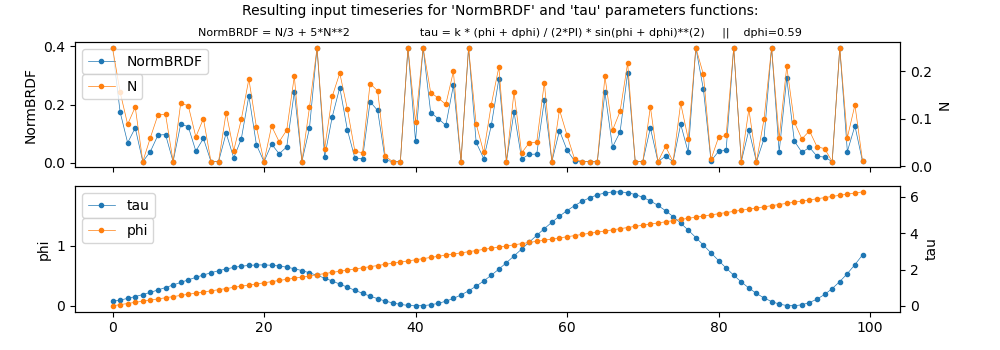

In [5]:
f, (ax, ax2) = plt.subplots(2, figsize=(10, 3.5), sharex=True, gridspec_kw=dict(hspace=0.15))
f.canvas.header_visible = False
f.text(0.5, .99, "Resulting input timeseries for 'NormBRDF' and 'tau' parameters functions:", ha="center", va="top")
f.text(.5, .92, f"NormBRDF = {R._NormBRDF}                    tau = {R._tau}     ||    dphi={dphi}", ha="center", va="top", fontsize=8)

ax.plot(R.NormBRDF, marker=".", lw=0.5, label="NormBRDF")
ax.set_ylabel("NormBRDF")
ax.legend(loc="upper left")

ax_t = ax.twinx()
ax_t.plot(N, marker=".", lw=0.5, label="N", c="C1")
ax_t.set_xlabel("# measurement")
ax_t.set_ylabel("N")
ax_t.legend(loc="upper left", bbox_to_anchor=(0, .8))

ax2.plot(R.tau, marker=".", lw=0.5, label="tau")
ax2.set_ylabel("phi")
ax2.legend(loc="upper left")

ax2_t = ax2.twinx()
ax2_t.plot(phi, marker=".", lw=0.5, label="phi", c="C1")

ax2_t.set_ylabel("tau")
ax2_t.legend(loc="upper left", bbox_to_anchor=(0, .8))
f.subplots_adjust(left=0.075, right=0.9)


## Setup scipy optimize to fit RT1 model to the data

In [6]:
def parse_params(x):
    """Map 1D parameter array to dict {parameter_name: value(s)}."""
    return dict(omega=x[0], k=x[1], dphi=x[2], N=x[3:][:, np.newaxis])

def fun(x):
    """Calculate residuals."""
    R.update_params(**parse_params(x), **const_params)
    res = (R.calc()[0] - tot).ravel() # Ravel output because scipy requires 1D arrays
    return res

def jac(x):
    """Calculate jacobian."""
    R.update_params(**parse_params(x), **const_params)
    jac = R.jacobian(param_list=["omega", "k", "dphi", "N"], format="scipy_least_squares")
    return jac


# Unpack start-values and boundaries as required by scipy optimize
x0 = [*start_vals["omega"], *start_vals["k"], *start_vals["dphi"], *start_vals["N"]]
bounds = list(zip(*[*bnd_vals["omega"], *bnd_vals["k"], *bnd_vals["dphi"], *bnd_vals["N"]]))

res = least_squares(
    fun=fun,
    x0=x0,
    bounds=bounds,
    jac=jac,
    #x_scale="jac",
    ftol=1e-5,
    gtol=1e-5,
    xtol=1e-5,
    verbose=2,
)

# Unpack found parameters
found_params = parse_params(res.x)
# Calcuate total backscatter based on found parameters
found_tot = R.calc(**found_params, **const_params)[0]

print([key, np.mean(val)] for key, val in found_params.items())


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.7912e+00                                    5.25e+00    
       1              2         7.3730e-01      9.05e+00       6.22e-01       1.00e+00    
       2              4         4.6641e-01      2.71e-01       1.20e-01       1.91e+00    
       3              6         3.7954e-01      8.69e-02       6.02e-02       1.71e+00    
       4              7         3.3956e-01      4.00e-02       6.37e-02       1.42e+00    
       5              8         2.6721e-01      7.24e-02       5.59e-02       1.07e+00    
       6              9         1.9543e-01      7.18e-02       5.19e-02       7.49e-01    
       7             10         1.3891e-01      5.65e-02       4.79e-02       4.81e-01    
       8             11         1.0043e-01      3.85e-02       4.05e-02       3.10e-01    
       9             12         7.5464e-02      2.50e-02       2.97e-02       1.66e-01    

      40             44         3.8839e-03      6.72e-04       3.90e-02       7.78e-02    
      41             45         3.3386e-03      5.45e-04       3.62e-02       7.06e-02    
      42             46         2.8926e-03      4.46e-04       3.35e-02       6.24e-02    
      43             47         2.5473e-03      3.45e-04       3.11e-02       5.43e-02    
      44             48         2.2772e-03      2.70e-04       2.92e-02       4.68e-02    


      45             49         2.0695e-03      2.08e-04       2.77e-02       4.01e-02    
      46             50         1.9086e-03      1.61e-04       2.65e-02       3.44e-02    
      47             51         1.7845e-03      1.24e-04       2.53e-02       2.98e-02    
      48             52         1.6901e-03      9.44e-05       2.40e-02       2.65e-02    
      49             53         1.6187e-03      7.14e-05       2.21e-02       2.39e-02    


      50             54         1.5667e-03      5.21e-05       1.92e-02       2.11e-02    
      51             55         1.5319e-03      3.47e-05       1.45e-02       1.64e-02    
      52             56         1.5199e-03      1.20e-05       1.09e-02       1.75e-02    
      53             57         1.5076e-03      1.23e-05       5.15e-03       1.19e-02    
      54             58         1.5030e-03      4.53e-06       3.60e-03       9.31e-03    


      55             59         1.4999e-03      3.09e-06       3.11e-03       7.20e-03    
      56             60         1.4977e-03      2.25e-06       2.82e-03       5.47e-03    
      57             61         1.4960e-03      1.72e-06       2.65e-03       4.00e-03    
      58             62         1.4946e-03      1.38e-06       2.59e-03       2.73e-03    
      59             63         1.4935e-03      1.14e-06       2.64e-03       1.59e-03    


      60             64         1.4925e-03      9.03e-07       2.58e-03       6.11e-04    
      61             65         1.4916e-03      9.78e-07       3.56e-03       6.07e-04    
      62             66         1.4909e-03      6.53e-07       3.12e-03       9.07e-04    
      63             67         1.4904e-03      5.46e-07       2.69e-03       1.26e-03    
      64             68         1.4899e-03      5.20e-07       2.50e-03       1.61e-03    


      65             69         1.4893e-03      5.20e-07       2.15e-03       1.83e-03    
      66             70         1.4889e-03      4.04e-07       1.85e-03       1.92e-03    
      67             71         1.4885e-03      3.88e-07       1.67e-03       1.95e-03    
      68             72         1.4882e-03      3.45e-07       1.52e-03       1.94e-03    
      69             73         1.4879e-03      3.30e-07       1.30e-03       1.89e-03    


      70             74         1.4876e-03      2.77e-07       1.23e-03       1.84e-03    
      71             75         1.4874e-03      2.29e-07       1.08e-03       1.79e-03    
      72             76         1.4871e-03      2.20e-07       9.64e-04       1.72e-03    
      73             77         1.4870e-03      1.70e-07       8.96e-04       1.67e-03    
      74             78         1.4868e-03      1.49e-07       8.57e-04       1.63e-03    


      75             79         1.4867e-03      1.34e-07       7.83e-04       1.59e-03    
      76             80         1.4866e-03      1.29e-07       6.93e-04       1.53e-03    
      77             81         1.4864e-03      1.13e-07       6.64e-04       1.48e-03    
      78             82         1.4863e-03      1.05e-07       5.92e-04       1.43e-03    
      79             83         1.4863e-03      8.83e-08       5.80e-04       1.38e-03    


      80             84         1.4862e-03      8.25e-08       5.16e-04       1.34e-03    
      81             85         1.4861e-03      7.18e-08       5.07e-04       1.30e-03    
      82             86         1.4860e-03      6.40e-08       4.75e-04       1.27e-03    
      83             87         1.4860e-03      6.15e-08       4.35e-04       1.23e-03    
      84             88         1.4859e-03      7.79e-08       2.17e-05       5.17e-04    
`xtol` termination condition is satisfied.
Function evaluations 88, initial cost 7.8421e+00, final cost 1.4859e-03, first-order optimality 5.17e-04.
<generator object <genexpr> at 0x0000027DB8D33900>


## Visualize Results
### Plot timeseries

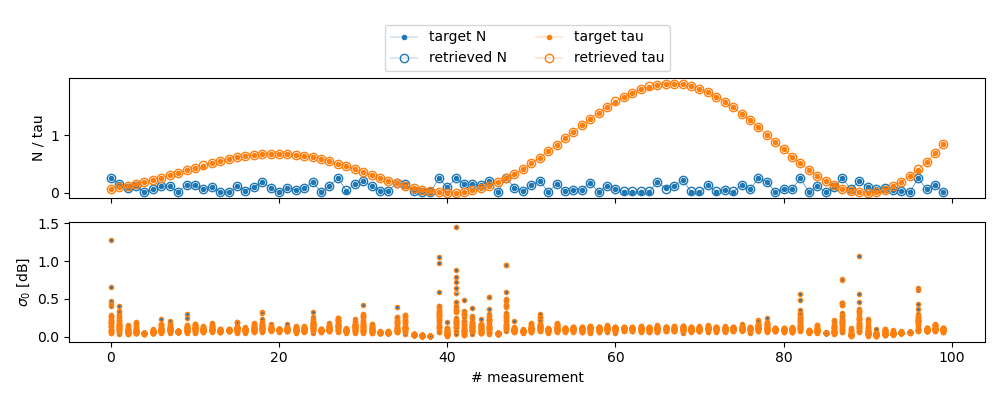

In [7]:
f, (ax, ax2) = plt.subplots(2, figsize=(10, 4), sharex=True)
f.canvas.header_visible = False

# Plot retrieved parameter timeseries
ax.set_ylabel("N / tau")

ax.plot(sim_params["N"], marker=".", lw=0.25, label="target N", c="C0")
ax.plot(found_params["N"], marker="o", lw=0.25, markerfacecolor="none", label="retrieved N", c="C0")

R.update_params(**sim_params, **const_params)
ax.plot(R.tau, marker=".", lw=0.25, label="target tau", c="C1")
R.update_params(**found_params, **const_params)
ax.plot(R.tau, marker="o", lw=0.25, markerfacecolor="none", label="retrieved tau", c="C1")

# Plot backscatter timeseries
ax2.set_ylabel(r"$\sigma_0$ [dB]")
ax2.set_xlabel("# measurement")

ax2.plot(tot, lw=0, marker=".", c="C0", ms=3)
ax2.plot(found_tot, lw=0, marker="o", markerfacecolor="none", c="C1", ms=3)

ax.legend(loc="upper center", ncols=2, bbox_to_anchor=(0.5, 1.5))
f.tight_layout()

### Initialize analyzer widget and overlay results

21:05:45.882 INFO: Evaluating coefficients for interaction-term...
21:05:45.931 INFO: Coefficients extracted, it took 0.01256 sec.


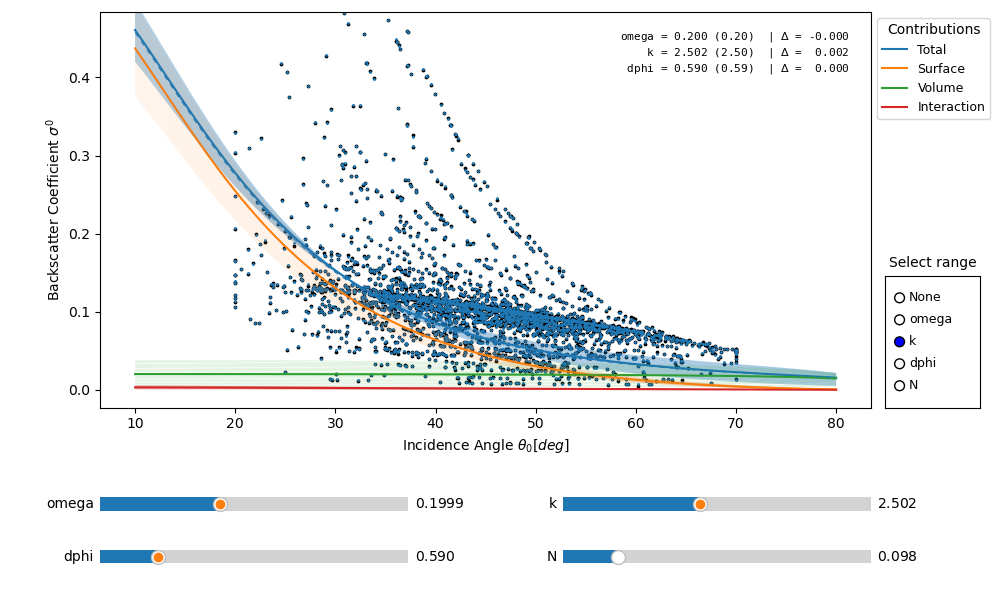

In [8]:
analyze_params = {key: (*np.mean(np.atleast_2d(bnd_vals[key]), axis=0), found_params[key].mean()) for key in found_params}
# pick the measurement for which you want to analyze the components
R.update_params(phi=0)

ana = R.analyze(**analyze_params, range_parameter="k")

# Plot fit-data on top
ana.ax.scatter(inc, tot, c="k", s=3, zorder=0)
ana.ax.scatter(inc, found_tot, c="C0", s=1, zorder=0)

# Indicate fit-results in slider-axes
for key, s in ana.sliders.items():
    if key in ["omega", "k", "dphi"]:
        s.ax.plot(sim_params[key], np.mean(s.ax.get_ylim()), marker="o")

# Add text for static parameters
t = ana.f.text(
    0.6,
    0.95,
    "\n".join(
        [
            f"{key:>8} = {found_params[key]:.3f} ({sim_params[key]:.2f})  "
            rf"| $\Delta$ = {found_params[key] - sim_params[key]: .3f}"
            for key in ["omega", "k", "dphi"]
        ]
    ),
    va="top",
    fontdict=dict(family="monospace", size=8),
)